In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torch.nn as nn

from trainer import Trainer

### Utility Functions

In [2]:
def get_device():
    """Get available device"""

    if torch.cuda.is_available():
        print("Using CUDA...")
        return torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print("Using MPS...")
        return torch.device("mps")
    else:
        print("Using CPU...")
        return torch.device("cpu")

def imshow(img):
    """Display CIFAR10 image"""
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
# setup device
device = get_device()

Using MPS...


### Load CIFAR-10 dataset

In [4]:
BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# split into 80-20 train and validation dataset
train_set, val_set = torch.utils.data.random_split(train_set, [0.95, 0.05])
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Input Tensor: torch.Size([3, 32, 32])
Label: 5


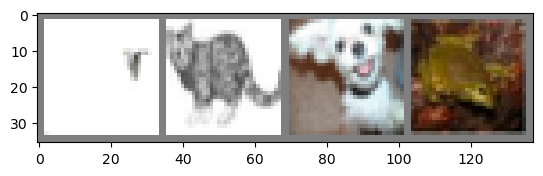

bird  cat   dog   frog 


In [5]:
# get one sample
images, labels = train_set[0]

print(f"Input Tensor: {images.shape}")
print(f"Label: {labels}")

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### Training Existing ResNet-18 Model
We will call PyTorch's existing implementation the baseline model

In [7]:
baseline_net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

# drop last linear layer and fit new linear layer for CIFAR-10
baseline_net.fc = nn.Linear(in_features=512, out_features=10)
baseline_net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
# setup trainer class to fine-tune ResNet-18
baseline_trainer = Trainer(baseline_net, model_name="baseline_pytorch_resnet18", batch_size=BATCH_SIZE, device=device)
baseline_trainer.train(train_dataloader, val_dataloader)

100%|██████████| 157/157 [00:27<00:00,  5.81it/s, loss=0.685]

INFO | Validation...


INFO | [EPOCH 0] LOSS : train=0.8977319207161095 val=0.7273117989301682 | ACCURACY : train=0.6941182613372803 val=0.758105456829071


100%|██████████| 157/157 [00:27<00:00,  5.80it/s, loss=0.55] 

INFO | Validation...


INFO | [EPOCH 1] LOSS : train=0.5436011406646413 val=0.6938336834311485 | ACCURACY : train=0.814963161945343 val=0.7674804925918579


100%|██████████| 157/157 [00:26<00:00,  5.99it/s, loss=0.432]

INFO | Validation...


INFO | [EPOCH 2] LOSS : train=0.40421393096067343 val=0.6711508169770241 | ACCURACY : train=0.8630075454711914 val=0.78076171875


100%|██████████| 157/157 [00:26<00:00,  5.99it/s, loss=0.325]

INFO | Validation...


INFO | [EPOCH 3] LOSS : train=0.3121196466266729 val=0.6755677238106728 | ACCURACY : train=0.8953025341033936 val=0.7925781011581421


100%|██████████| 157/157 [00:26<00:00,  6.01it/s, loss=0.27] 

INFO | Validation...


INFO | [EPOCH 4] LOSS : train=0.24047522422424547 val=0.7331172734498977 | ACCURACY : train=0.9179189801216125 val=0.781933605670929


100%|██████████| 157/157 [00:26<00:00,  6.00it/s, loss=0.206]

INFO | Validation...


INFO | [EPOCH 5] LOSS : train=0.1881355019226955 val=0.7826646164059639 | ACCURACY : train=0.9358329772949219 val=0.7876952886581421


100%|██████████| 157/157 [00:26<00:00,  5.99it/s, loss=0.149]

INFO | Validation...


INFO | [EPOCH 6] LOSS : train=0.1420371308685488 val=0.7867002561688423 | ACCURACY : train=0.9520302414894104 val=0.791796863079071


100%|██████████| 157/157 [00:26<00:00,  5.88it/s, loss=0.151] 

INFO | Validation...


INFO | [EPOCH 7] LOSS : train=0.12439081371779655 val=0.8115326225757599 | ACCURACY : train=0.9594197869300842 val=0.791699230670929


100%|██████████| 157/157 [00:26<00:00,  6.02it/s, loss=0.12]  

INFO | Validation...


INFO | [EPOCH 8] LOSS : train=0.11375794163460184 val=0.7717579491436481 | ACCURACY : train=0.9621566534042358 val=0.8089843988418579


100%|██████████| 157/157 [00:26<00:00,  6.02it/s, loss=0.112] 

INFO | Validation...


INFO | [EPOCH 9] LOSS : train=0.09661434780640207 val=0.829286053776741 | ACCURACY : train=0.9666102528572083 val=0.7987304925918579


INFO | Test accuracy: 79.7265625 %


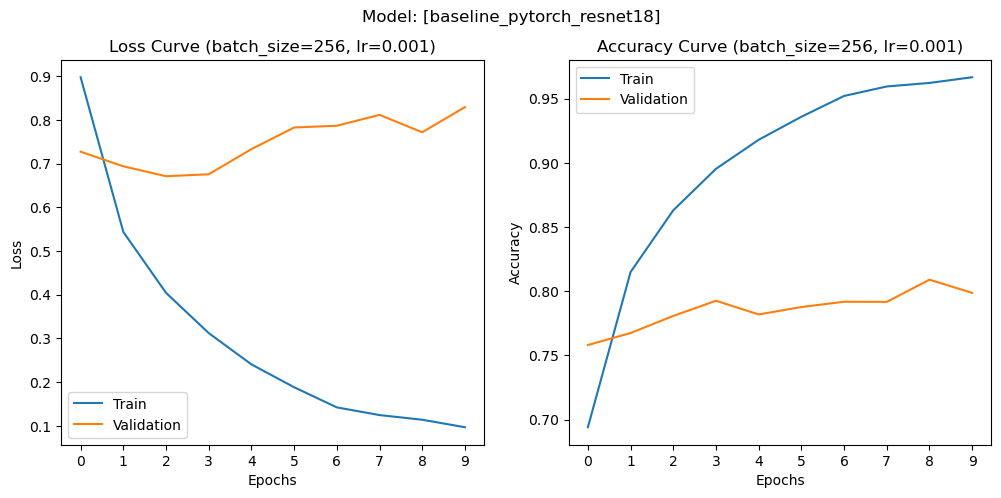

In [9]:
baseline_trainer.test(test_dataloader)
baseline_trainer.plot_metrics()

### Training My PyTorch Implementation of ResNet-18

In [10]:
from resnet18 import ResNet18

resnet = ResNet18.from_pretrained("resnet18")
print("lfg, we didn't crash!")
resnet_trainer = Trainer(resnet, device=device)
resnet_trainer.train(train_dataloader, val_dataloader)

loading weights from pytorch pretrained resnet18
lfg, we didn't crash!


100%|██████████| 157/157 [00:46<00:00,  3.35it/s, loss=0.665]

INFO | Validation...


INFO | [EPOCH 0] LOSS : train=0.8985162335596267 val=0.7450468868017197 | ACCURACY : train=0.6958101391792297 val=0.751953125


100%|██████████| 157/157 [00:45<00:00,  3.42it/s, loss=0.538]

INFO | Validation...


INFO | [EPOCH 1] LOSS : train=0.5416945826475787 val=0.6392113447189331 | ACCURACY : train=0.8150378465652466 val=0.7862304449081421


100%|██████████| 157/157 [00:45<00:00,  3.43it/s, loss=0.462]

INFO | Validation...


INFO | [EPOCH 2] LOSS : train=0.4066487956958212 val=0.6598362147808075 | ACCURACY : train=0.8623108863830566 val=0.784960925579071


100%|██████████| 157/157 [00:46<00:00,  3.38it/s, loss=0.324]

INFO | Validation...


INFO | [EPOCH 3] LOSS : train=0.30725191818301084 val=0.6276153527200222 | ACCURACY : train=0.8943570852279663 val=0.796191394329071


100%|██████████| 157/157 [00:51<00:00,  3.03it/s, loss=0.271]

INFO | Validation...


INFO | [EPOCH 4] LOSS : train=0.23526061378466856 val=0.7395321935415268 | ACCURACY : train=0.9212031960487366 val=0.784375011920929


100%|██████████| 157/157 [00:56<00:00,  2.76it/s, loss=0.204]

INFO | Validation...


INFO | [EPOCH 5] LOSS : train=0.1845545392412289 val=0.6865658067166805 | ACCURACY : train=0.937823474407196 val=0.806445300579071


100%|██████████| 157/157 [00:56<00:00,  2.79it/s, loss=0.16] 

INFO | Validation...


INFO | [EPOCH 6] LOSS : train=0.14999102772610962 val=0.8398643046617508 | ACCURACY : train=0.9496417045593262 val=0.784472644329071


100%|██████████| 157/157 [00:56<00:00,  2.80it/s, loss=0.173] 

INFO | Validation...


INFO | [EPOCH 7] LOSS : train=0.1298534760524513 val=0.7144435226917267 | ACCURACY : train=0.9552647471427917 val=0.8041015863418579


100%|██████████| 157/157 [04:33<00:00,  1.74s/it, loss=0.113]

INFO | Validation...


INFO | [EPOCH 8] LOSS : train=0.10985584746880137 val=0.7938898101449012 | ACCURACY : train=0.9626045227050781 val=0.801074206829071


100%|██████████| 157/157 [00:55<00:00,  2.85it/s, loss=0.121] 

INFO | Validation...


INFO | [EPOCH 9] LOSS : train=0.09307408249776834 val=0.7595378284342587 | ACCURACY : train=0.968550980091095 val=0.807910144329071


INFO | Test accuracy: 80.185546875 %


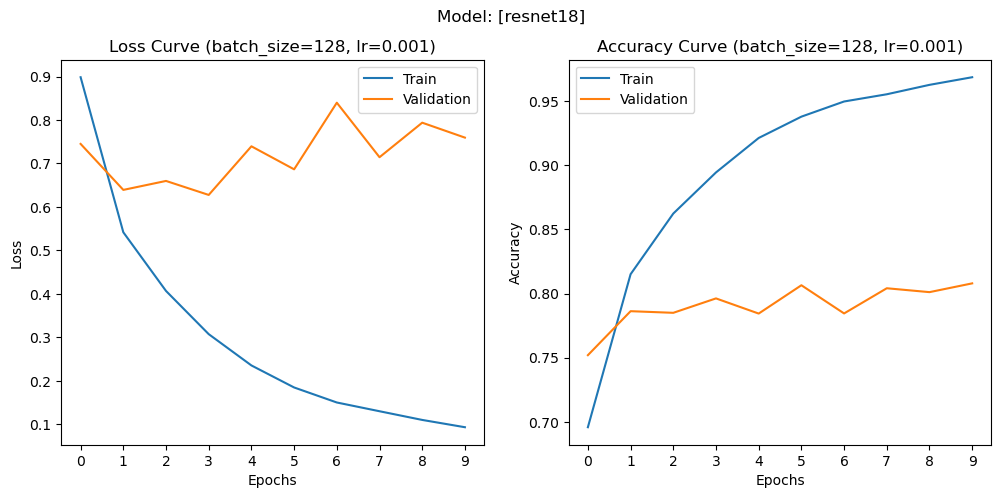

In [11]:
resnet_trainer.test(test_dataloader)
resnet_trainer.plot_metrics()

# Acknowledgements

- [PyTorch CIFAR10 Training Tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
- [A Detailed Introduction to ResNet and Its Implementation in PyTorch](https://medium.com/@freshtechyy/a-detailed-introduction-to-resnet-and-its-implementation-in-pytorch-744b13c8074a) by Huili Yu
- [Let's reproduce GPT-2 (124M)](https://www.youtube.com/watch?v=l8pRSuU81PU) by Andrej Karpathy
- [Helpful conventions for PyTorch model building](https://github.com/FrancescoSaverioZuppichini/Pytorch-how-and-when-to-use-Module-Sequential-ModuleList-and-ModuleDict/blob/master/README.md) by FrancescoSaverioZuppichini  